## The Problem
- Regularization
1. Construa uma arquitetura de rede neural simples e a regularize-a utilizando o mecanismo
de ensemble. Defina formalmente a estrat´egia de ensemble adotada

- Muitos alunos estão me procurando para perguntar se uma análise comparativa entre modelos/hyperparameters poderia ser considerado como tópico do artigo da disciplina. Recomendo FORTEMENTE que vocês procurem fazer algo diferente. Vejam, por exemplo, os exercícios 2 e 3 da lista Convolutional Networks; exercícios 1, 2 e 3 da lista de Regularization; exercício 6 de Basic Hyperparameters; 5 da lista de Deep Learning.

- No geral, prefiro que vocês proponham algum ensemble (i.e., aprendendo a ponderar os membros do ensemble) de redes neurais do que um artigo que passe a mensagem “Modelo X supera Y que, por sua vez, é melhor que Z. Porém, analisando o custo computacional Z é mais eficiente que X”.

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import plot
import os
import contextlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from utils.samples_generator import make_spiral
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification

from keras.layers import Dense, Input,BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

In [44]:
#input_dim, output_dim = x.shape[1], z.shape[1]
models = []
accuracies = []
ann_list = []
num_models = 5

## Auxiliary Functions

In [45]:
def compute_variance(numbers):
    if not numbers:
        return 0

    # Calculate the mean of the numbers
    mean = sum(numbers) / len(numbers)
    # Calculate the squared differences from the mean
    squared_diffs = [(x - mean) ** 2 for x in numbers]
    # Calculate the variance
    variance = round(sum(squared_diffs) / len(numbers),2)
    return variance

In [46]:
def plot_decision_boundary(model, X, y, threshold, figsize=(12,6), s=15, cmap=plt.cm.viridis):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
    

    if model is not None:
        plt.subplot(1, 2, 2, sharex=ax, sharey=ax)

        # Create a mesh grid
        x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
        y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))
    
        # Predict class for each point in the mesh grid
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = (Z > 0.5).astype(int).reshape(xx.shape)
        Z = np.where(Z <= threshold, 0, 1)
        
        # Plot the data points
        scatter = plt.scatter(X[:, 0], X[:, 1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
        #plt.xlabel('Feature 1')
        #plt.ylabel('Feature 2')
        #plt.title('Decision Boundary {:.2f}%'.format(acc))
        #plt.title('Decision Boundary {:.2f}%'.format(acc))
        #plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
        #plt.show()
        
        # Plot the decision boundary
        plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

In [47]:
class ANN_accuracy: 
    def __init__(self, accuracy, neuralNetwork): 
        self.accuracy = accuracy 
        self.ann = neuralNetwork

### Chosing members

In [48]:
def identify_worst_elements(ann_list_members, num_worst=1):
    """
    Identify the worst elements in a list of ANN_accuracy objects based on accuracy.

    Parameters:
    ann_list_members (list of ANN_accuracy): The list to check for the worst elements.
    num_worst (int): The number of worst elements to identify.

    Returns:
    list of ANN_accuracy: The worst elements from the list.
    """
    # Sort the list by accuracy in ascending order
    sorted_list = sorted(ann_list_members, key=lambda x: x.accuracy)
    
    # Select the worst elements
    worst_elements = sorted_list[:num_worst]
    
    return worst_elements

In [49]:
def remove_worst_elements(ann_list_members, num_worst=1):
    """
    Remove the worst elements from a list of ANN_accuracy objects based on accuracy.

    Parameters:
    ann_list_members (list of ANN_accuracy): The list to remove the worst elements from.
    num_worst (int): The number of worst elements to remove.

    Returns:
    list of ANN_accuracy: The list with the worst elements removed.
    """
    # Make a copy of the list to avoid modifying the original list
    ann_list_copy = ann_list_members[:]
    
    # Identify the worst elements
    worst_elements = identify_worst_elements(ann_list_copy, num_worst)
    
    # Remove the worst elements from the copied list
    for element in worst_elements:
        ann_list_copy.remove(element)
    
    return ann_list_copy

In [50]:
def identify_best_elements(ann_list_members, num_best=1):
    """
    Identify the best elements in a list of ANN_accuracy objects based on accuracy.

    Parameters:
    ann_list_members (list of ANN_accuracy): The list to check for the best elements.
    num_best (int): The number of best elements to identify.

    Returns:
    list of ANN_accuracy: The best elements from the list.
    """
    # Sort the list by accuracy in descending order
    sorted_list = sorted(ann_list_members, key=lambda x: x.accuracy, reverse=True)
    
    # Select the best elements
    best_elements = sorted_list[:num_best]
    
    return best_elements

### Members evaluation

# Ensemble approach

The ensemble strategy adopted is the arithmetic mean of the individual models' predictions. Formally, this can be described as follows:

$\widehat{y} = \frac{1}{M} \sum_{m=1}^M \widehat{y}_m$

where:
- $\widehat{y}$ is the final prediction of the ensemble.
- $M$ is the number of models in the ensemble.
- $\widehat{y}_m$ is the prediction of the \(m\)-th model.

This approach improves the model's robustness and reduces overfitting, as individual model errors tend to be smoothed out in the average.

In [51]:
#Binary classification using probabilities:
def ensemble_predictions(members, testX):
    # Make predictions
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        yhats = [model.predict(testX) for model in members]
        
    # Average predictions
    averaged = np.mean(np.array(yhats), axis=0)
    # Apply threshold to get binary predictions
    result = (averaged > 0.5).astype(int).flatten()
    return result

In [52]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
 # select a subset of members
 subset = members[:n_members]
 # make prediction
 yhat = ensemble_predictions(subset, testX)
 # calculate accuracy
 return accuracy_score(testy, yhat)

In [53]:
def compute_ensemble_scores(ensemble_members):
    # evaluate different numbers of ensembles on hold out set
    my_nn = NeuralNetwork()
    single_scores, ensemble_scores = list(), list()
    for i in range(1, len(models)+1):
        # evaluate model with i members
        ensemble_score = evaluate_n_members(ensemble_members, i, X_test, y_test)
        # evaluate the i'th model standalone
        if isinstance(ensemble_members[i-1], type(my_nn)):
            single_score = accuracy_score(y_test,ensemble_members[i-1].predict(X_test) > 0.5)
        else:   
            _, single_score = ensemble_members[i-1].evaluate(X_test, y_test, verbose=0)
            
        ensemble_score = round(100*ensemble_score,4)
        single_score = round(100*single_score,4)
        # summarize this step
        print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
        ensemble_scores.append(ensemble_score)
        single_scores.append(single_score)

    return ensemble_scores, single_scores

In [54]:
def ensemble_result(committee):
    models.clear()
    accuracies.clear()
    for element in committee:
        #print(f'Neural Network: {element.ann}, Accuracy: {element.accuracy}')
        models.append(element.ann)
        accuracies.append(element.accuracy)

    # Evaluate ensemble
    ensemble_scores, single_scores = compute_ensemble_scores(models)
    ensemble_pred = ensemble_predictions(models, X_test)
    ensemble_acc = round(100*accuracy_score(y_test, ensemble_pred),4)
    ensemble_variance = compute_variance(accuracies)

    print('Ensemble Accuracy: {:.2f}%'.format(ensemble_acc))
    plot_scores_num_members(models,single_scores,ensemble_scores, ensemble_acc,ensemble_variance)

    return ensemble_acc

#### Another approaches

In [55]:
weights = [0.1, 0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1, 0.1]
def weighted_average_ensemble(models, X, weights=None):
    """
    Combines predictions from multiple models using a weighted average.

    Args:
        models: A list of machine learning models.
        X: The input dataset.
        weights: A list of weights for each model. If None, all models receive equal weights.

    Returns:
        A NumPy array with the combined predictions.
    """
    if weights is None:
        weights = [1/len(models)] * len(models)
    predictions = np.zeros((X.shape[0], 1))
    for model, weight in zip(models, weights):
        predictions += weight * model.predict(X)
    return predictions

In [56]:
def ensemble_predictions_voting(members, testX):
    """
    Combines predictions from multiple models using majority voting. Considering models output as labels.

    Args:
        members: A list of machine learning models.
        testX: The input dataset for prediction.

    Returns:
        A NumPy array with the combined predictions based on majority voting.
    """
    # Make predictions
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        yhats = [model.predict(testX) for model in members] 
    
    # Sum across ensemble members
    summed = np.sum(np.array(yhats), axis=0)
    # Apply majority voting to get binary predictions
    result = (summed > (len(members) / 2)).astype(int)
    return result

### Plot results

In [57]:
def plot_scores_num_members(models,single_scores,ensemble_scores, ensemble_acc, ensemble_variance):
    plt.figure(figsize=(10, 6))
    
    # plot score vs number of ensemble members
    x_axis = [i for i in range(1, len(models)+1)]
    plt.plot(x_axis, single_scores, marker='o', linestyle='None',label=f'Single Accuracy')
    plt.plot(x_axis, ensemble_scores, marker='o', label=f'Cumulative Ensemble Accuracy')
    
    # Highlighting the ensemble accuracy
    plt.axhline(y=ensemble_acc, color='r', linestyle='--', label=f'Ensemble Accuracy ({ensemble_acc})')

    # Highlighting the ensemble accuracy
    #plt.axhline(y=weighted_accuracy, color='g', linestyle=':', label=f'Ensemble weighted_average Accuracy ({weighted_accuracy})')

    # Adding a dummy line for ensemble variance
    plt.plot([], [], ' ', label=f'Ensemble Variance ({ensemble_variance})')

    # Adding text annotations for each point
    #for i, score in enumerate(single_scores):
    #    plt.annotate(f'{score:.4f}', (x_axis[i], single_scores[i]), textcoords="offset points", xytext=(0,5), ha='center')

    #for i, score in enumerate(ensemble_scores):
    #    plt.annotate(f'{score:.4f}', (x_axis[i], ensemble_scores[i]), textcoords="offset points", xytext=(0,5), ha='center')
    
    
    # Adding title and labels
    plt.title('Model Accuracies vs Ensemble Accuracy')
    plt.xlabel('Ensemble Members')
    plt.ylabel('Accuracy')

    # Adding legend
    plt.legend()
    plt.show()

## Dataset definition

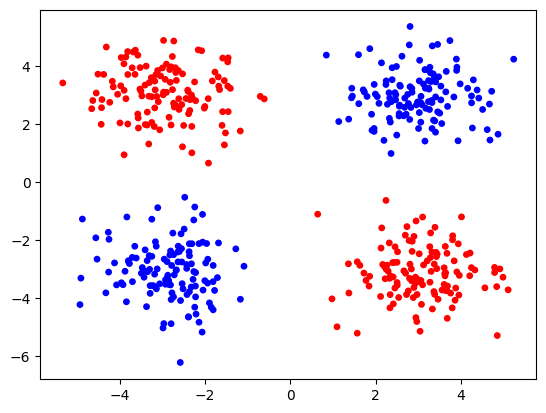

In [58]:
#x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234) #- ok
#x, y = make_moons(200, noise=0.20,random_state=1234) #- ok

x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234) #- ok
y = np.where(y >= 2, 1, 0) #used  for for blobs

#x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75,random_state=1234) # ok

#standard deviation of 2.0 means that the classes are not linearly separable (separable by a line) causing many ambiguous points.
#This is desirable as it means that the problem is non-trivial and will allow a neural network model to find many different “good enough” candidate solutions resulting in a high variance.
#x, y = make_blobs(n_samples=500, centers=2, n_features=2, cluster_std=2, random_state=1234)

#print(x.shape, y.shape, z.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y.reshape(-1, 1)).ravel()), s=15, cmap='bwr')

In [59]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
#plt.scatter(X_train[:,0], X_train[:,1], c=list(np.array(y_train).ravel()), s=15, cmap='bwr')
print(X_train.shape, y_train.shape)

(335, 2) (335,)


## Custom NN

In [60]:
def create_evaluate_my_model(X_train, y_train, X_test, y_test):
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    input_dim, output_dim = X_train.shape[1], y_train.shape[1]

    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = 1e-1)

    nn.layers.append(Layer(input_dim=input_dim, output_dim=20,activation=rna.tanh)) # tanh pois incli sen/cos 
    nn.layers.append(Layer(input_dim=20, output_dim=20,activation=rna.tanh,batch_norm=True))  #uso da batch normalization - função de custo melhor e passamos de 10k para 5k epochs
    #nn.layers.append(Layer(input_dim=20, output_dim=20,activation=rna.tanh,batch_norm=True))  #uso da batch normalization - função de custo melhor e passamos de 10k para 5k epochs
    
    nn.layers.append(Layer(input_dim=20, output_dim=output_dim,activation=rna.sigmoid,batch_norm=True)) 
    
    nn.fit(X_train, y_train, epochs=1000, verbose=1000,batch_gen= rna.batch_sequential, batch_size = 10) 
    y_pred = nn.predict(X_test)
    acc = accuracy_score(y_test, y_pred > 0.5)

    return nn, round(100*acc,4)

epoch:    0/1000 loss_train: 0.22845111 + 0.00000000 = 0.22845111 loss_val = 0.22845111
epoch: 1000/1000 loss_train: 0.00002628 + 0.00000000 = 0.00002628 loss_val = 0.00002628
epoch:    0/1000 loss_train: 0.55620058 + 0.00000000 = 0.55620058 loss_val = 0.55620058
epoch: 1000/1000 loss_train: 0.00000966 + 0.00000000 = 0.00000966 loss_val = 0.00000966
epoch:    0/1000 loss_train: 0.23408685 + 0.00000000 = 0.23408685 loss_val = 0.23408685
epoch: 1000/1000 loss_train: 0.00001893 + 0.00000000 = 0.00001893 loss_val = 0.00001893
epoch:    0/1000 loss_train: 0.22707158 + 0.00000000 = 0.22707158 loss_val = 0.22707158
epoch: 1000/1000 loss_train: 0.00002201 + 0.00000000 = 0.00002201 loss_val = 0.00002201
epoch:    0/1000 loss_train: 0.27345665 + 0.00000000 = 0.27345665 loss_val = 0.27345665
epoch: 1000/1000 loss_train: 0.00003875 + 0.00000000 = 0.00003875 loss_val = 0.00003875
Accuracy over the testing dataset: 99.3939%


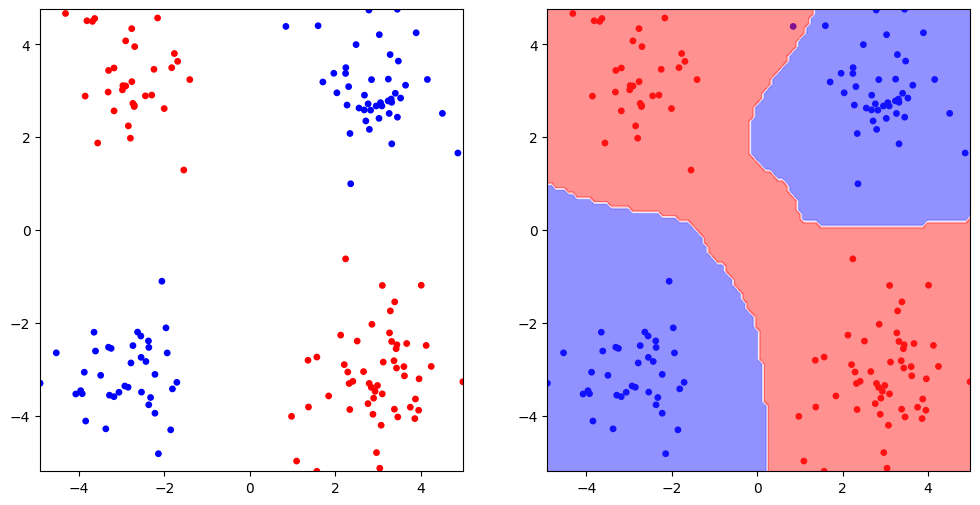

In [61]:
for _ in range(num_models):
    model, acc = create_evaluate_my_model(X_train, y_train, X_test, y_test)
    models.append(model)
    accuracies.append(acc)
    ann_list.append(ANN_accuracy(acc,model))

print('Accuracy over the testing dataset: {:.4f}%'.format(acc))
plot.classification_predictions(X_test, y_test.reshape(-1, 1), is_binary=True, nn=model, threshold=0.5, cmap='bwr')

## Keras NN

In [62]:
def create_evaluate_model(X_train, y_train, X_test, y_test):
    input_shape = X_train.shape[1]
    inputs = Input(shape=(input_shape,))
    
    dense = Dense(units=20, activation="tanh")(inputs)
    dense = BatchNormalization()(dense)

    dense = Dense(units=20, activation="tanh")(dense)
    dense = BatchNormalization()(dense)

    #dense = Dense(units=20, activation="tanh")(dense)
    #dense = BatchNormalization()(dense)
       
    outputs = Dense(units=1, activation="sigmoid")(dense)

    model = Model(inputs=inputs, outputs=outputs)
    opt = SGD(learning_rate=0.01)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=0) 
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)


    return model, round(100*accuracy,4)


Accuracy over the testing dataset: 98.7879%
44477/44477 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step


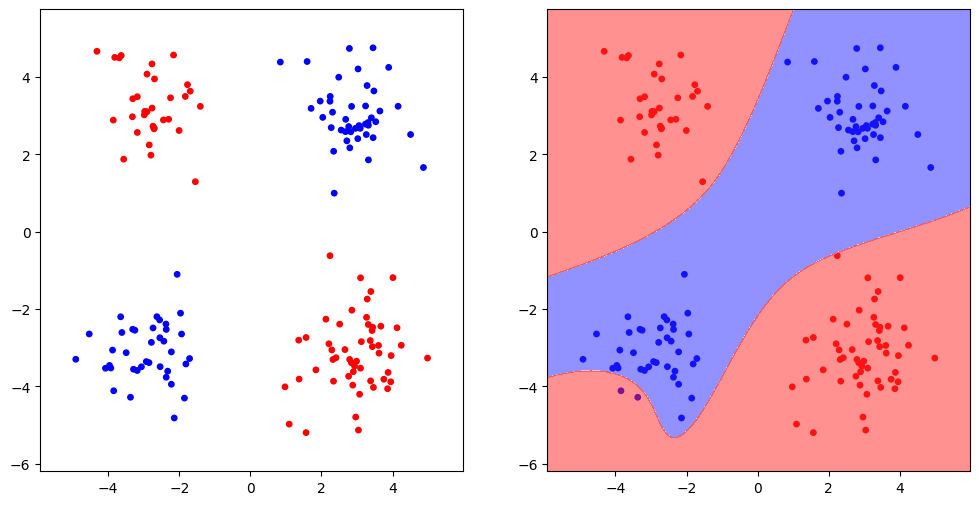

In [63]:
for _ in range(num_models):
    model, acc = create_evaluate_model(X_train, y_train, X_test, y_test)
    #model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=0)
    models.append(model)
    accuracies.append(acc)
    ann_list.append(ANN_accuracy(acc,model))

print('Accuracy over the testing dataset: {:.4f}%'.format(acc))
plot_decision_boundary(model, X_test, y_test.reshape(-1, 1),threshold=0.5, cmap='bwr')

## Ensemble NN

In [64]:
# Removing the two worst models from the committee.
list_to_prune = ann_list[:]
#for element in list_to_prune:
#    print(f'Neural Network: {element.ann}, Accuracy: {element.accuracy}')

#print(f'The worst list')
worst_elements = identify_worst_elements(list_to_prune, num_worst=3)
#for element in worst_elements:
#    print(f'Neural Network: {element.ann}, Accuracy: {element.accuracy}')

without_the_worst_committee = remove_worst_elements(list_to_prune, num_worst=2)

In [65]:
# Selecting the 5 best models from the committee
list_to_select = ann_list[:]
# Get the 2 best elements
the_best_committee = identify_best_elements(list_to_select, num_best=5)
# Print the best elements
#for element in the_best_committee:
#    print(f'Neural Network: {element.ann}, Accuracy: {element.accuracy}')

In [66]:
# ensemble predictions
y_pred_train = weighted_average_ensemble(models, X_train, weights)
y_pred_test = weighted_average_ensemble(models, X_test, weights)

# predictions to binary classes
y_pred_train_class = (y_pred_train > 0.5).astype(int)
y_pred_test_class = (y_pred_test > 0.5).astype(int)

# assess ensemble accuracy
train_accuracy = round(100*np.mean(y_pred_train_class == y_train.reshape(-1, 1)),2)
#test_accuracy = round(100*np.mean(y_pred_test_class == y_test.reshape(-1, 1)),2)
weighted_accuracy = np.mean(y_pred_test_class == y_test.reshape(-1, 1))
weighted_accuracy = round(100*weighted_accuracy,4)

print(f"Ensemble Train Accuracy: {train_accuracy:.4f}")
print(f"Ensemble weighted Accuracy: {weighted_accuracy:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Ensemble Train Accuracy: 100.0000
Ensemble weighted Accuracy: 100.00


## Results

In [67]:
print('{}'.format(accuracies))

[100.0, 99.3939, 100.0, 100.0, 99.3939, 84.2424, 99.3939, 100.0, 100.0, 98.7879]


In [68]:
#ensemble_variance = round(compute_variance(accuracies),2)
ensemble_variance = compute_variance(accuracies)

> 1: single=100.000, ensemble=100.000
> 2: single=99.394, ensemble=99.394
> 3: single=100.000, ensemble=100.000
> 4: single=100.000, ensemble=100.000
> 5: single=99.394, ensemble=100.000
> 6: single=84.242, ensemble=100.000
> 7: single=99.394, ensemble=100.000
> 8: single=100.000, ensemble=100.000
> 9: single=100.000, ensemble=100.000
> 10: single=98.788, ensemble=100.000
Ensemble Accuracy: 100.00%


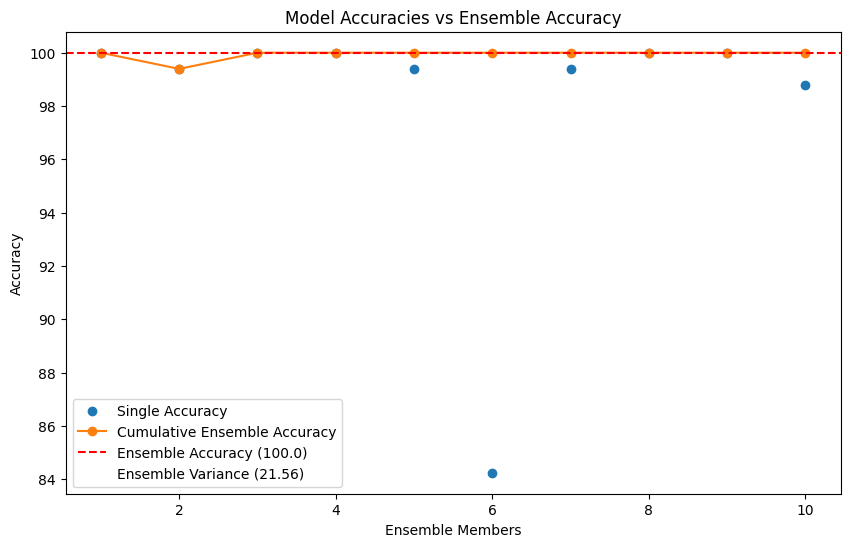

In [69]:
#First Approach - Calculate the ensemble accuracy based on the whole commitee.
#The chart below show the performance of each individual model as a blue dot and the ensemble of increasing size (number of members) 
# from 1 to 10 members as an orange line.
ensemble_acc = ensemble_result(ann_list)

> 1: single=100.000, ensemble=100.000
> 2: single=99.394, ensemble=99.394
> 3: single=100.000, ensemble=100.000
> 4: single=100.000, ensemble=100.000
> 5: single=99.394, ensemble=100.000
> 6: single=99.394, ensemble=100.000
> 7: single=100.000, ensemble=100.000
> 8: single=100.000, ensemble=100.000
Ensemble Accuracy: 100.00%


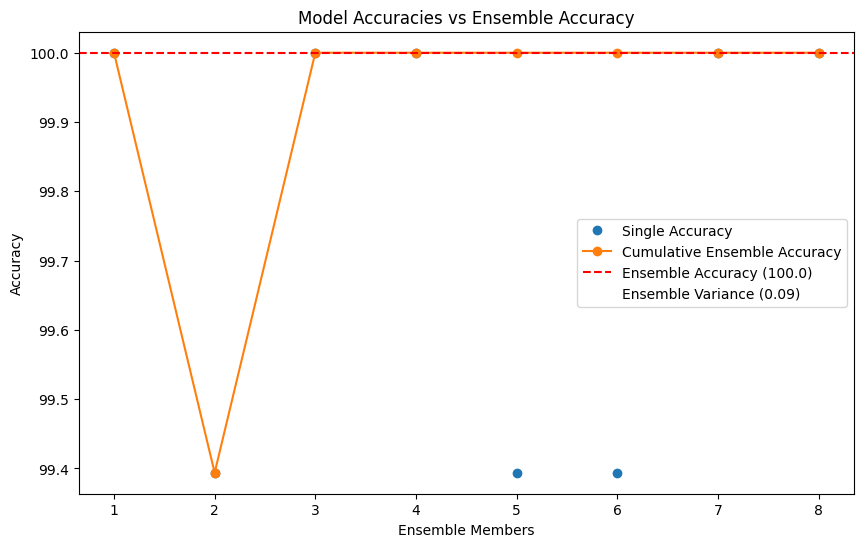

In [70]:
#Second Approach - Calculate the ensemble accuracy based on the commitee without the two worst members
#The chart below show the performance of each individual model as a blue dot and the ensemble of increasing size (number of members) 
# from 1 to 8 members as an orange line.
ensemble_acc = ensemble_result(without_the_worst_committee)

> 1: single=100.000, ensemble=100.000
> 2: single=100.000, ensemble=100.000
> 3: single=100.000, ensemble=100.000
> 4: single=100.000, ensemble=100.000
> 5: single=100.000, ensemble=100.000
Ensemble Accuracy: 100.00%


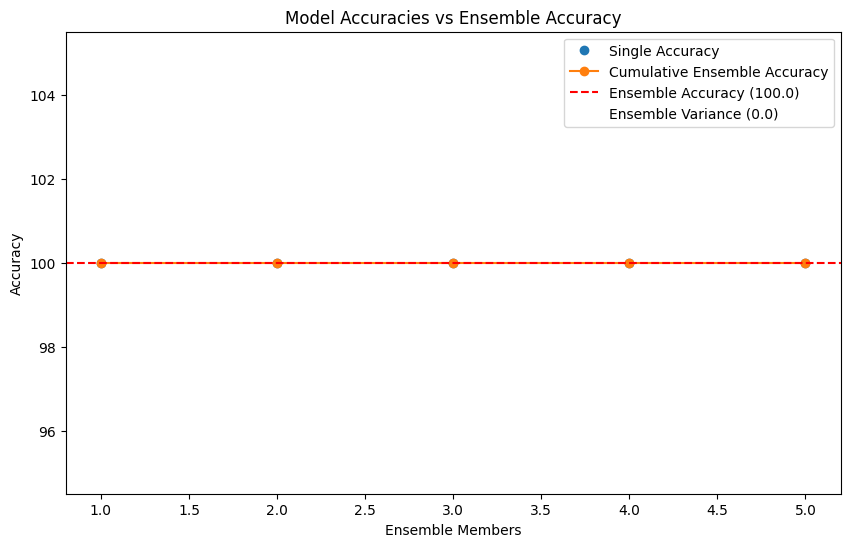

In [71]:
#Third Approach - Calculate the ensemble accuracy based on a subset of the commitee with the five best performance members
#The chart below show the performance of each individual model as a blue dot and the ensemble of increasing size (number of members) 
# from 1 to 5 members as an orange line.
ensemble_acc = ensemble_result(the_best_committee)

## Result Analysis

In [72]:
# Creating the dataframe from collected data from previous executions
data = {
    'dataset': ['make_circles', 'make_moons', 'make_blob_clusters', 'make_spiral', 'make_blobs'],
   
    'accuracy_10_members':      [50.91, 95.45, 100, 89.39, 52.12],
    'accuracy_without_2_worst': [99.39, 95.45, 100, 90.91, 93.33],
    'accuracy_5_best':          [100, 96.97, 100, 92.42, 95.15],
   
    'variance_10_members':      [331.83, 14.72, 0.96, 178.51, 156.73],
    'variance_without_2_worst': [50.96, 12.63, 0.59, 97.24, 0.28],
    'variance_5_best':          [2.00, 11.39, 0.06, 29.02, 0.09]
}

df = pd.DataFrame(data)

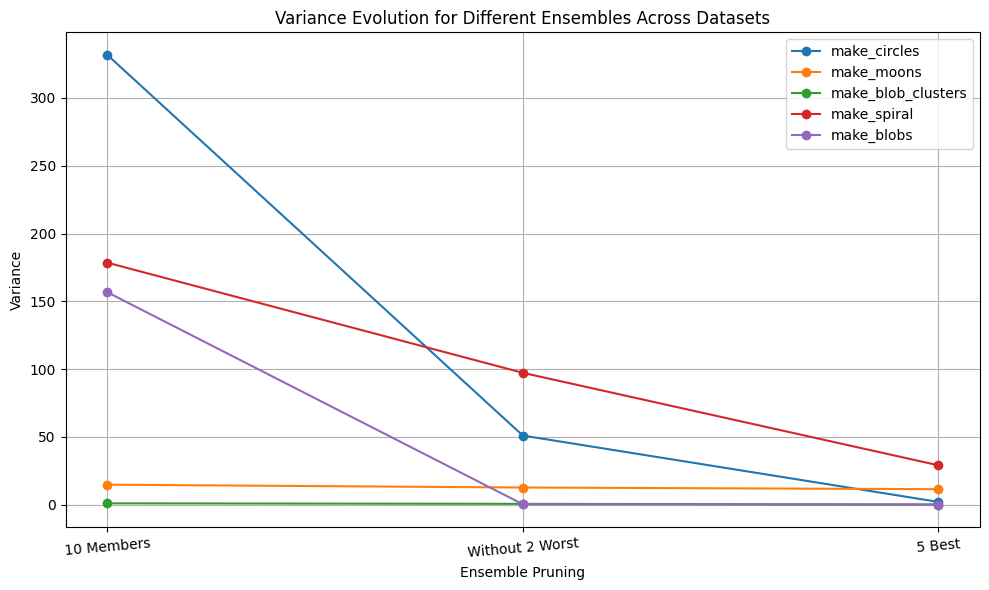

In [73]:
# Evolution of variance across different configurations for each dataset
plt.figure(figsize=(10, 6))

# Plotting for each dataset
for dataset in df['dataset']:
    plt.plot(['10 Members', 'Without 2 Worst', '5 Best'],
             [df.loc[df['dataset'] == dataset, 'variance_10_members'].values[0],
              df.loc[df['dataset'] == dataset, 'variance_without_2_worst'].values[0],
              df.loc[df['dataset'] == dataset, 'variance_5_best'].values[0]],
             marker='o', label=dataset)

plt.xlabel('Ensemble Pruning')
plt.ylabel('Variance')
plt.title('Variance Evolution for Different Ensembles Across Datasets')
plt.legend()
plt.grid(True)
plt.xticks(rotation=5)

# Show plot
plt.tight_layout()
plt.show()

#This plot shows the evolution of variance for different configurations across each dataset. Each line represents a dataset and shows how its variance changes under the three configurations: 10 members, without the 2 worst, and the 5 best. If you need further adjustments or additional analysis, please let me know! ​

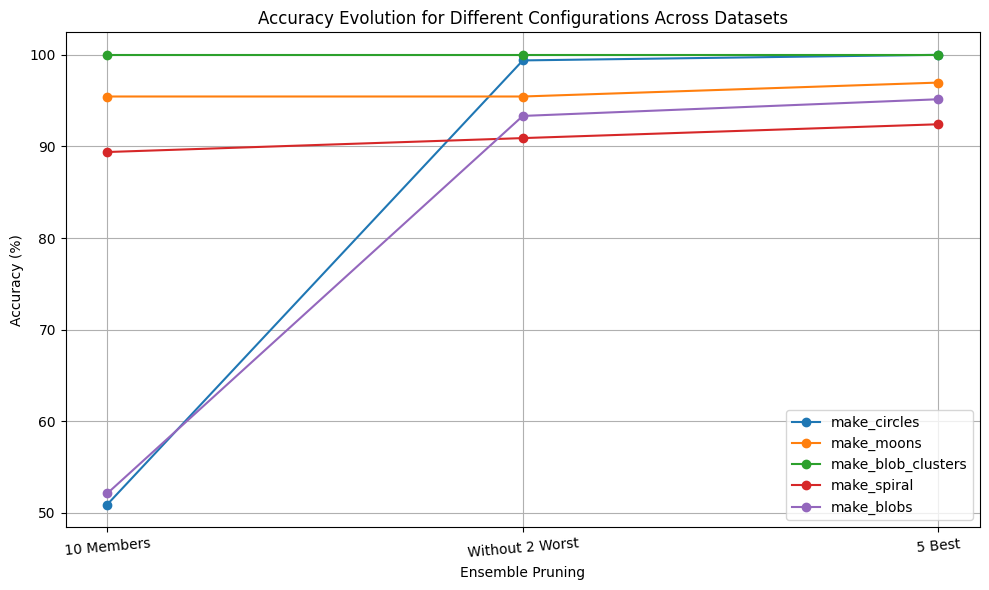

In [74]:
# Plotting the accuracies
plt.figure(figsize=(10, 6))

# Plotting for each dataset
for dataset in df['dataset']:
    plt.plot(['10 Members', 'Without 2 Worst', '5 Best'],
             [df.loc[df['dataset'] == dataset, 'accuracy_10_members'].values[0],
              df.loc[df['dataset'] == dataset, 'accuracy_without_2_worst'].values[0],
              df.loc[df['dataset'] == dataset, 'accuracy_5_best'].values[0]],
             marker='o', label=dataset)

plt.xlabel('Ensemble Pruning')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution for Different Configurations Across Datasets')
plt.legend()
plt.grid(True)
plt.xticks(rotation=5)

# Show plot
plt.tight_layout()
plt.show()


The plot shows the evolution of accuracy for different configurations across each dataset. Each line represents a dataset and illustrates how its accuracy changes under the three configurations: 10 members, without the 2 worst, and the 5 best.

Analysis:
- make_circles: Significant improvement from 10 members (50.91%) to configurations without the 2 worst (99.39%) and the 5 best (100%).
- make_moons: High accuracy across all configurations with minor improvements, showing consistent performance.
- make_blob_clusters: Perfect accuracy (100%) across all configurations, indicating robustness.
- make_spiral: Noticeable improvements in accuracy from 10 members (89.39%) to the other two configurations, peaking at 5 best (92.42%).
- make_blobs: Significant increase from 10 members (52.12%) to the other configurations, reaching up to 95.15% in the 5 best configuration.

This analysis reveals that excluding the worst members and selecting the best members generally improves accuracy, especially for datasets with lower initial accuracies. The make_blob_clusters dataset stands out with consistent perfect accuracy.

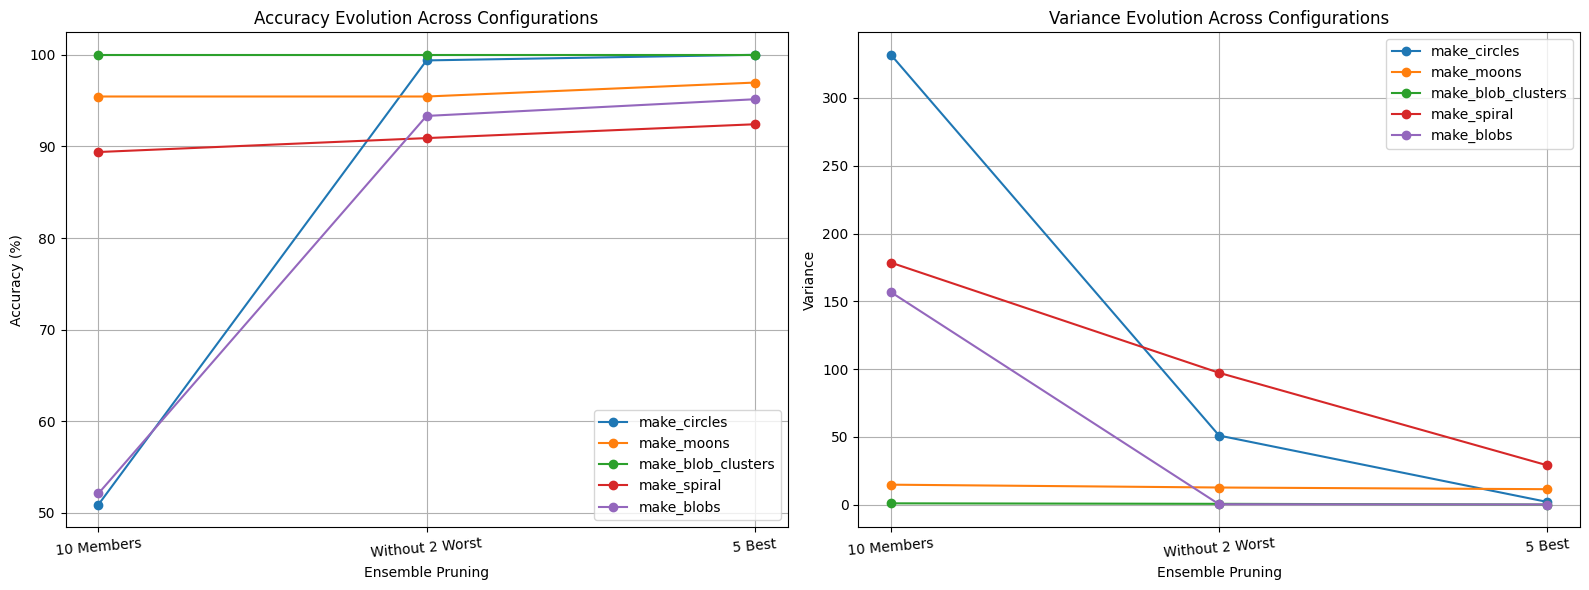

In [75]:
# Creating subplots for accuracy and variance side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting accuracy
for dataset in df['dataset']:
    axes[0].plot(['10 Members', 'Without 2 Worst', '5 Best'],
                 [df.loc[df['dataset'] == dataset, 'accuracy_10_members'].values[0],
                  df.loc[df['dataset'] == dataset, 'accuracy_without_2_worst'].values[0],
                  df.loc[df['dataset'] == dataset, 'accuracy_5_best'].values[0]],
                 marker='o', label=dataset)

axes[0].set_xlabel('Ensemble Pruning')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy Evolution Across Configurations')
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=5)

# Plotting variance
for dataset in df['dataset']:
    axes[1].plot(['10 Members', 'Without 2 Worst', '5 Best'],
                 [df.loc[df['dataset'] == dataset, 'variance_10_members'].values[0],
                  df.loc[df['dataset'] == dataset, 'variance_without_2_worst'].values[0],
                  df.loc[df['dataset'] == dataset, 'variance_5_best'].values[0]],
                 marker='o', label=dataset)

axes[1].set_xlabel('Ensemble Pruning')
axes[1].set_ylabel('Variance')
axes[1].set_title('Variance Evolution Across Configurations')
axes[1].legend()
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=5)

# Adjust layout
plt.tight_layout()
plt.show()


The correlations between accuracy and variance for each configuration are as follows:

- 10 Members: -0.800
    - Strong negative correlation indicating that as accuracy increases, variance tends to decrease significantly.

- Without 2 Worst: -0.337
    - Moderate negative correlation showing that higher accuracy is somewhat associated with lower variance.

- 5 Best: -0.698
    - Strong negative correlation suggesting that higher accuracy is again associated with lower variance.


- Analysis: Across all configurations, there is a negative correlation between accuracy and variance. The strongest negative correlation is observed in the 10 members configuration, followed by the 5 best configuration, and then the without 2 worst configuration. This indicates that improving accuracy tends to reduce variance, with the most pronounced effect when considering all 10 members.

## References
 - https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/
 - https://arxiv.org/pdf/2109.14117v1 (Neural Network Ensembles: Theory, Training, and the Importance of Explicit Diversity)
 - https://openreview.net/pdf?id=3s4hFx8pYs (tiny paper)
 - https://openreview.net/pdf?id=GTHD2UnDIb (tiny paper)
 - https://openreview.net/pdf?id=K3ilD3QhX6 (tiny paper)

 - https://openreview.net/group?id=ICLR.cc/2024/TinyPapers#tab-invite-to-present-notable (list of tiny papers)
 - https://www.sciencedirect.com/science/article/abs/pii/S1566253521002360
 - https://www.sciencedirect.com/science/article/abs/pii/S0305054824002119
 - https://www.geeksforgeeks.org/bias-vs-variance-in-machine-learning/